# Processing Nanopore reads

## Quality control

In [1]:
!NanoStat --summary ./sequencing_summary/*_sequencing_summary.txt --readtype 1D

General summary:	 
Active channels:	508
Mean read length:	512.7
Mean read quality:	9.1
Median read length:	471.0
Median read quality:	9.5
Number of reads:	2614814
Read length N50:	486
Total bases:	1340509039
Number, percentage and megabases of reads above quality cutoffs
>Q5:	2501301 (95.7%) 1311.1Mb
>Q7:	2338838 (89.4%) 1237.9Mb
>Q10:	896240 (34.3%) 488.7Mb
>Q12:	20433 (0.8%) 10.2Mb
>Q15:	0 (0.0%) 0.0Mb
Top 5 highest mean basecall quality scores and their read lengths
1:	14.3 (424; edb19951-2581-4e90-948e-353c9c5c2f2b)
2:	14.2 (507; fa4adcb2-356a-4146-ab71-08f255faf624)
3:	14.2 (445; 4480b9ed-54f8-4417-9947-d5eadfb8c803)
4:	14.1 (499; 03c42aef-7458-405b-835f-b9d74139014a)
5:	14.1 (487; a7dd7905-0507-43a6-a875-3872507e0b60)
Top 5 longest reads and their mean basecall quality score
1:	25758 (4.0; 3de0a886-65ea-4012-a9fa-9d6807173f79)
2:	14336 (4.1; 2fdd0a4f-0619-4dcd-8683-7dcc255177e8)
3:	7067 (7.8; 8f32aa34-3265-45db-b0f3-d89704c64162)
4:	4539 (8.7; 511aba4e-0fad-4e45-9fea-80ae6f2b34c9

## Demultiplexing using qcat

In [6]:
barcode_dirs = ["barcode"+x for x in ["{:02d}".format(i) for i in range(1,25)]]
for bd in barcode_dirs:
    !mkdir work2/{bd}

In [ ]:
!cat ./fastq_pass/*.fastq | qcat --dual -b ./work2 --trim

## Make a list of barcodes

I extract the detected barcodes from the `work` directory to use later.

In [1]:
import glob
all_files = glob.glob("work/*.fastq")
fastq_files = glob.glob("work/BC*.fastq")
barcodes = [fq.split("/")[1].split(".")[0] for fq in fastq_files]
barcodes

['BC10',
 'BC08',
 'BC04',
 'BC07',
 'BC03',
 'BC09',
 'BC06',
 'BC01',
 'BC12',
 'BC11',
 'BC05',
 'BC02']

## Summarise each output file

In [ ]:
for f in all_files:
    !echo {f};NanoStat -t 16 --fastq {f}; echo "\n"

## Identify references using Mash

The following uses a special curly brace syntax to loop through the barcodes.

In [ ]:
for bc in barcodes:
    !echo {bc};mash screen -p 16 -w refs/denv.msh work/{bc}.fastq > work/{bc}.screen

The following code sorts the Mash results, finds the top reference, and extracts it from the FASTA file.

In [ ]:
for bc in barcodes:
    !samtools faidx refs/denv.fas `sort -gr work/{bc}.screen | cut -f 5 | head -1` > work/{bc}_ref.fa

## Map using graphmap

In [ ]:
for bc in barcodes:
    !graphmap align -t 16 -r work/{bc}_ref.fa -d work/{bc}.fastq -o work/{bc}.graphmap.sam

## Convert, sort and index the BAM files

In [ ]:
for bc in barcodes:
    !samtools view -bS work/{bc}.graphmap.sam | samtools sort - -o work/{bc}.graphmap.bam

In [ ]:
for bc in barcodes:
    !samtools index work/{bc}.graphmap.bam

## Get coverage from BAM file

In [ ]:
for bc in barcodes:
    !mosdepth -t 16 work/{bc} work/{bc}.graphmap.bam

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

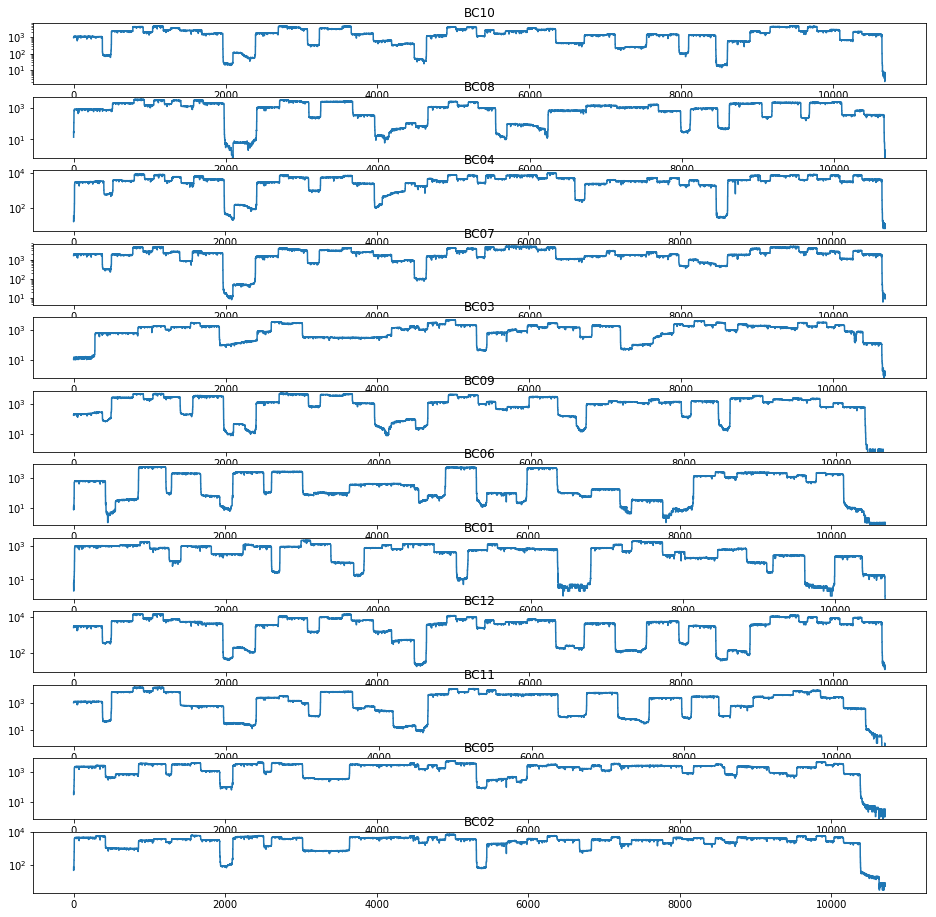

In [3]:
fig = plt.figure(figsize=[16,16])
for i in range(len(barcodes)):
    bc = barcodes[i]
    plt.subplot(len(barcodes), 1, i+1)
    df = pd.read_table("work/"+bc+".per-base.bed.gz",compression='gzip',sep='\t',header=None)
    plt.yscale('log')
    plt.title(bc)
    plt.step(df[1],df[3])

## Extract consensus from each BAM

In [ ]:
for bc in barcodes:
    !echo {bc}
    !kindel consensus work/{bc}.graphmap.bam > work/{bc}_consensus.fa

## Polish assemblies with Medaka

In [ ]:
!medaka consensus --help

In [ ]:
for bc in barcodes:
    !echo {bc}
    #!medaka consensus -i work/{bc}.fastq -d work/{bc}_consensus.fa -o work/{bc}_medaka -t 16 -m r941_trans

## Concatenate draft assemblies

In [ ]:
from Bio import SeqIO
records = []
for bc in barcodes:
    record=SeqIO.read("work/"+bc+"_consensus.fa",format="fasta")
    record.id=bc
    record.name=bc
    record.description=bc
    records.append(record)
SeqIO.write(records,"work/consensus.fa",format="fasta")

## Concatenate sequences with references

In [ ]:
!cat refs/denv.fas work/consensus.fa > work/consensus_withrefs.fa

## Align sequences

In [ ]:
!fftnsi --thread 16 work/consensus_withrefs.fa > work/consensus_withrefs.fa.fftnsi

## Make a quick tree

In [ ]:
!iqtree -s work/consensus_withrefs.fa.fftnsi -m GTR+G4 -nt 4 -pre work/consensus_withrefs -fast